In [2]:
import io
import numpy as np
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense, LSTM,Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import files
data_to_load = files.upload()
import tensorflow as tf

import seaborn as sb

Saving humid_dataz.csv to humid_dataz.csv


     HUMID_DATE  AVERAGE HUMIDITY  TEMP  WIND   RAIN
0    01.01.1931                72  -3.9   2.7   22.3
1    01.02.1931                 0  -5.4   2.4   13.2
2    01.03.1931                 0   0.8   2.8   30.2
3    01.04.1931                 0  11.1   4.4    3.4
4    01.05.1931                 0  18.3   2.6  100.6
..          ...               ...   ...   ...    ...
955  01.08.2010                33  26.5   1.6    0.0
956  01.09.2010                48  20.6   1.2   52.0
957  01.10.2010                66  12.9   1.0   20.6
958  01.11.2010                74   8.7   0.8   22.8
959  01.12.2010                83   1.3   0.8   59.3

[960 rows x 5 columns]


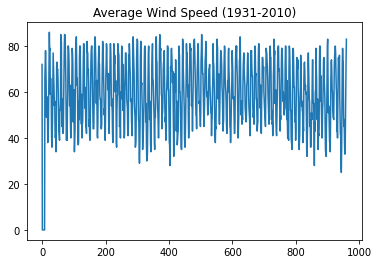

In [11]:
df=pd.read_csv(io.BytesIO(data_to_load['humid_dataz.csv']))
print(df)
temp=df['AVERAGE HUMIDITY']
plt.title('Average Wind Speed (1931-2010)')
plt.plot(temp)

In [4]:

df=pd.read_csv(io.BytesIO(data_to_load['humid_dataz.csv']))
train_dates=pd.to_datetime(df['HUMID_DATE'], format='%d.%m.%Y')
cols=list(df)[1:5]
print(cols)
df_for_train=df[cols].astype(float)
scaler=StandardScaler()
scaler=scaler.fit(df_for_train)
df_for_train_scaled=scaler.transform(df_for_train)

xtrain=[]
ytrain=[]

train_years= pd.to_datetime(df['HUMID_DATE'])

n_predicts=1
n_past=4

for i in range(n_past,len(df_for_train_scaled)-n_predicts+1):
    xtrain.append(df_for_train_scaled[i-n_past:i,0:df_for_train.shape[1]])
    ytrain.append(df_for_train_scaled[i+n_predicts-1:i+n_predicts,0])
xtrain,ytrain=np.array(xtrain),np.array(ytrain)
#print(xtrain)
#print(ytrain)

print('The shape of xtrain is===:{}'.format(xtrain.shape))
print('The shape of ytrain is===:{}'.format(ytrain.shape))

['AVERAGE HUMIDITY', 'TEMP', 'WIND', 'RAIN']
The shape of xtrain is===:(956, 4, 4)
The shape of ytrain is===:(956, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
54/54 - 3s - loss: 0.8722 - val_loss: 0.8144 - 3s/epoch - 51ms/step
Epoch 2/150
54/54 - 0s - loss: 0.4189 - val_loss: 0.3355 - 216ms/epoch - 4ms/step
Epoch 3/150
54/54 - 0s

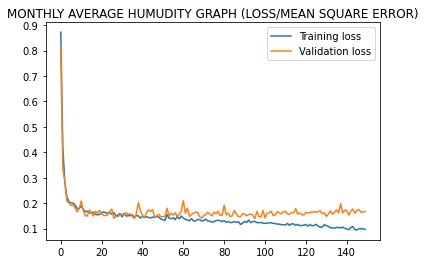

In [5]:
#defining the model here

model=Sequential()
model.add(LSTM(64,activation='relu',input_shape=(xtrain.shape[1],xtrain.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(ytrain.shape[1]))
model.compile(optimizer='adam',loss='mse')
model.summary()

#fitting the model

histoz=model.fit(xtrain,ytrain,epochs=150,batch_size=16,validation_split=0.1,verbose=2)

#plotting the training graph
plt.title('MONTHLY AVERAGE HUMUDITY GRAPH (LOSS/MEAN SQUARE ERROR)')
plt.plot(histoz.history['loss'],label='Training loss')
plt.plot(histoz.history['val_loss'],label='Validation loss')
plt.legend()




In [15]:
n_predicts=5
forecast_period_months=pd.date_range(list(train_dates)[-1],periods=n_predicts,freq='1y').tolist()
forecast=model.predict(xtrain[-n_predicts:])

forecast_copies=np.repeat(forecast,df_for_train.shape[1],axis=-1)
y_predict_future=scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates=[]

for time_i in forecast_period_months:
  forecast_dates.append(time_i.date())

df_forecast=pd.DataFrame({'HUMID_DATE':np.array(forecast_dates),'AVERAGE HUMIDITY':y_predict_future})
df_forecast['HUMID_DATE']=pd.to_datetime(df_forecast['HUMID_DATE'])

original=df[['HUMID_DATE','AVERAGE HUMIDITY']]
original['HUMID_DATE']=pd.to_datetime(original['HUMID_DATE'])
original=original.loc[original['HUMID_DATE']>='1950-01-01']


sb.lineplot(original['HUMID_DATE'], original['AVERAGE HUMIDITY'])
sb.lineplot (df_forecast['HUMID_DATE'],df_forecast['AVERAGE HUMIDITY'])



1/1 [==============================] - 0s 18ms/step


<ipython-input-15-5c8c2bcaefe3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['HUMID_DATE']=pd.to_datetime(original['HUMID_DATE'])


TypeError: ignored